In [19]:
import numpy as np
import dask as da
import fmm.hilbert as hilbert

from fmm.octree import Octree

In [20]:
npoints = 20
maximum_level = 3

rand = np.random.RandomState(0)
sources = rand.rand(npoints, 3)
targets = rand.rand(npoints, 3)

tree = Octree(sources, targets, maximum_level)

In [21]:
task_graph = {}

def local_to_multipole(leaf_node_index):
    """Compute multipole expansion from local sources."""
    leaf_id = tree.source_leaf_nodes[leaf_node_index]
    source_indices = tree.sources_by_leafs[
        tree.source_index_ptr[leaf_node_index] : tree.source_index_ptr[leaf_node_index + 1]
    ]
    # Have the source indices. Can now compute the multipole expansion
    pass
    
    
def m2m(node_id, child_expansions):
    """Upward pass of multipole expansion"""
    pass

def m2l(node_id, interaction_list):
    pass

def l2l(node_id, dependencies):
    pass

def l2p(node, l2l_interaction, m2l_interaction):
    pass

def stringify(char, number):
    return char + str(number)

def upward_pass():
    """Compute all upward passes."""
    global task_graph
    
    all_nodes = set(tree.non_empty_source_nodes)
    
    # First local to multipole on the leafs
    number_of_leafs = len(tree.source_index_ptr) - 1
    for index in range(number_of_leafs):
        task_graph[stringify('s', tree.source_leaf_nodes[index])] = (local_to_multipole, index)
        
    for index, key in enumerate(tree.non_empty_source_nodes):
        # Check if not a leaf
        if hilbert.get_level(key) == maximum_level: continue
        children = hilbert.get_children(key)
        child_input = []
        for child in children:
            if child in all_nodes:
                child_input.append(stringify('s', child))
        if child_input:
            task_graph[stringify('s', key)] = (m2m, key, child_input)

def interaction_list_is_empty(key):
    """Return for a key if it has empty interaction list."""
    return np.all(tree.interaction_list[tree.target_node_to_index[key]] == -1)

def has_l2l_support(key):
    """Get l2l support for a single node"""
    if key == 0:
        return False
    parent = hilbert.get_parent(key)
    return has_l2l_support(parent) or not interaction_list_is_empty(parent)


def compute_l2l_support(tree):
    """Return a list of nodes that have l2l contribution."""
    
    
    l2l_nodes = []
    
    for key in tree.non_empty_target_nodes:
        if has_l2l_support(key):
            l2l_nodes.append(key)
            
    return l2l_nodes
        
            
def downward_pass():
    """Compute all downward passes."""
    global task_graph
    
    all_nodes = set(tree.non_empty_target_nodes)
    l2l_nodes = compute_l2l_support(tree)
    
    result = []

    # First do the m2l part
    for index, key in enumerate(tree.non_empty_target_nodes):
        non_empty_interactions = np.extract(
            tree.interaction_list[index] != -1, tree.interaction_list[index]
        )
        my_interactions = []
        for interaction_node in non_empty_interactions:
            my_interactions.append(stringify('s', interaction_node))
        if my_interactions:
            task_graph[stringify('m', key)] = (m2l, key, my_interactions)
        
    # Now the l2l bit
    for key in tree.non_empty_target_nodes:
        if key == 0: continue
        parent = hilbert.get_parent(key)
        if has_l2l_support(key):
            dependencies = []
            if has_l2l_support(parent): dependencies.append(stringify('l', parent))
            if not interaction_list_is_empty(parent): dependencies.append(stringify('m', parent))
            task_graph[stringify('l', key)] = (l2l, key, dependencies)
                
    # Do the local 2 particle interactions
    for key in tree.target_leaf_nodes:
        l2l_dependency = None
        m2l_dependency = None
        if stringify('l', key) in task_graph:
            l2l_dependency = stringify('l', key)
        if stringify('m', key):
            m2l_dependency = stringify('m', key)
        task_graph[stringify('p', key)] = (l2p, key, l2l_dependency, m2l_dependency)
        result.append(stringify('p', key))
        
    return result
                
    

In [22]:
upward_pass()
particle_computations = downward_pass()

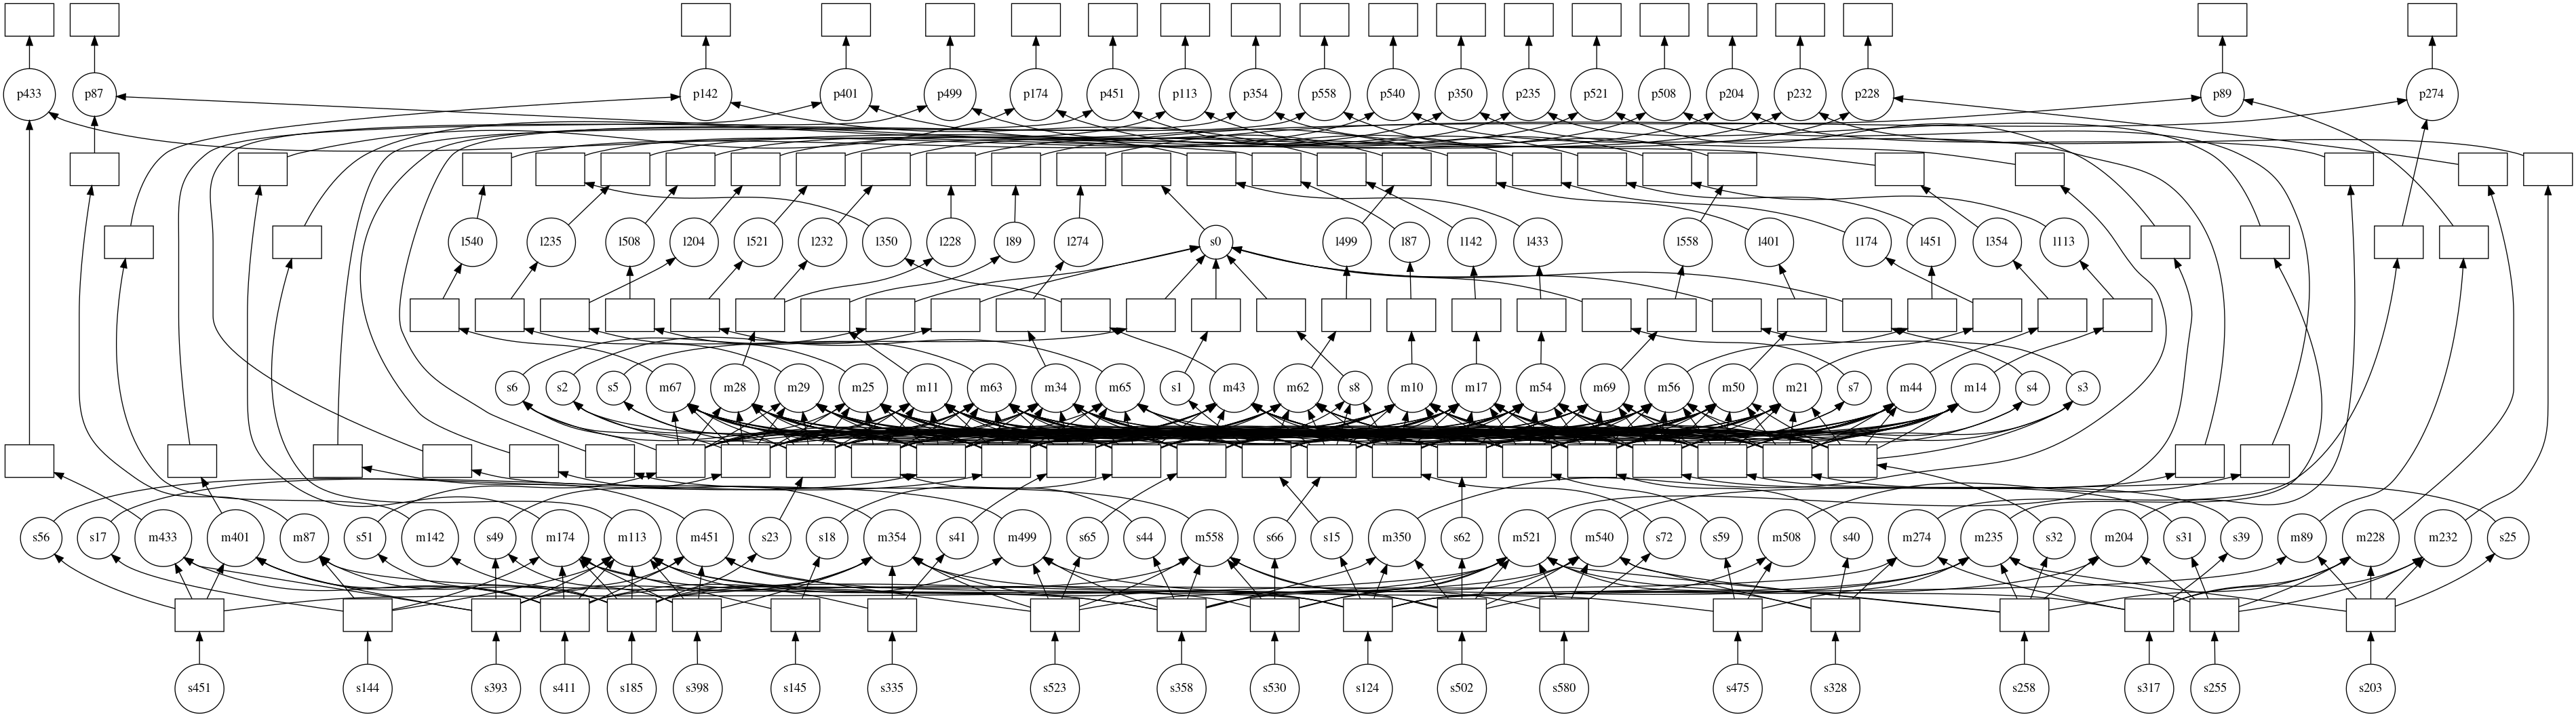

In [23]:
da.visualize(task_graph)